In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Input,MaxPooling2D,Dropout
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/gdrive/My Drive"))
style.use('ggplot')
%matplotlib notebook

['IDC_regular_ps50_idx5', 'Colab Notebooks', 'CBIS-DDSM final train_test mammogram data', 'CBIS-DDSM final cancer_normal mammogram data', 'full_CBIS-DDSM dataset']


In [ ]:
base_dir = '/content/gdrive/My Drive/CBIS-DDSM final train_test mammogram data'

#train autoencoder files
train_dir = os.path.join(base_dir,'train')

#train classification model files
test_dir = os.path.join(base_dir,'test')

train_cats = os.path.join(train_dir,'cancer')
train_dogs = os.path.join(train_dir,'normal')

test_cats = os.path.join(test_dir,'cancer')
test_dogs = os.path.join(test_dir,'normal')

#get filenames
train_cats_fnames = os.listdir(train_cats)
train_dogs_fnames = os.listdir(train_dogs)

(4712, 2648, 3)
(5888, 3000, 3)


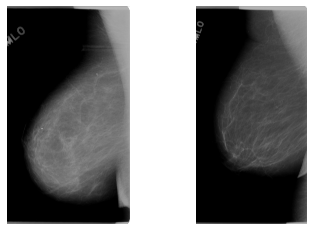

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

pic = [os.path.join(train_cats, train_cats_fnames[0])]
pic2 = [os.path.join(train_dogs, train_dogs_fnames[0])]

for i, img in enumerate(pic + pic2):
    ax = plt.subplot(1,2,i+1)
    image = mpimg.imread(img)
    ax.axis('off')
    plt.imshow(image)
    print(image.shape)

In [ ]:
input_img = Input(shape=(152,152, 3)) #RGB image

#encoder
x = Conv2D(16,(3,3),activation='relu',padding='same',)(input_img)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D(2,padding='same')(x)

# at this point the representation is (19, 19, 8)

#decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder=Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 152, 152, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 152, 152, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 76, 76, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 8)         0     

In [ ]:
# use all files in 'training' directory data to train autoencoder
# augment train data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train = ImageDataGenerator(rescale=1./255,
                          rotation_range=40, 
                          width_shift_range=0.2,
                          height_shift_range=0.2, 
                          shear_range=.2)

train_gen = train.flow_from_directory(train_dir,
                                    target_size=(152,152),
                                    batch_size=40,
                                    class_mode=None,
                                   )

Found 370 images belonging to 2 classes.


In [ ]:
#use "test" directory to train classification model

test = ImageDataGenerator(rescale=1./255, 
                          validation_split=.4) # split data to train/validation subsets

train_generator = test.flow_from_directory(test_dir,
                                  target_size=(152,152),
                                  batch_size=10,
                                  class_mode='binary',
                                  subset='training'
)
test_generator = test.flow_from_directory(test_dir,
                                  target_size=(152,152),
                                  batch_size=10,
                                  class_mode='binary',
                                  subset='validation'
)


Found 215 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


In [ ]:
#fit autoencoder model with training data

 
def fixed_generator(generator): # autoencoder don't feed labels, but 'fit_generator' need x,y values
    for batch in generator:
        yield (batch, batch)

hist = autoencoder.fit_generator(
    fixed_generator(train_gen),
    epochs = 10,
    steps_per_epoch=200)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
200/200 [==============================] - 967s 5s/step - loss: 0.6912
Epoch 2/10
200/200 [==============================] - 845s 4s/step - loss: 0.6907
Epoch 3/10
200/200 [==============================] - 846s 4s/step - loss: 0.6901
Epoch 4/10
200/200 [==============================] - 842s 4s/step - loss: 0.6894
Epoch 5/10
200/200 [==============================] - 844s 4s/step - loss: 0.6886
Epoch 6/10
200/200 [==============================] - 842s 4s/step - loss: 0.6876
Epoch 7/10
200/200 [==============================] - 839s 4s/step - loss: 0.6866
Epoch 8/10
200/200 [==============================] - 836s 4s/step - loss: 0.6854
Epoch 9/10
200/200 [==============================] - 842s 4s/step - loss: 0.6838
Epoch 10/10
200/200 [==============================] - 842s 4s/step - loss: 0.6820


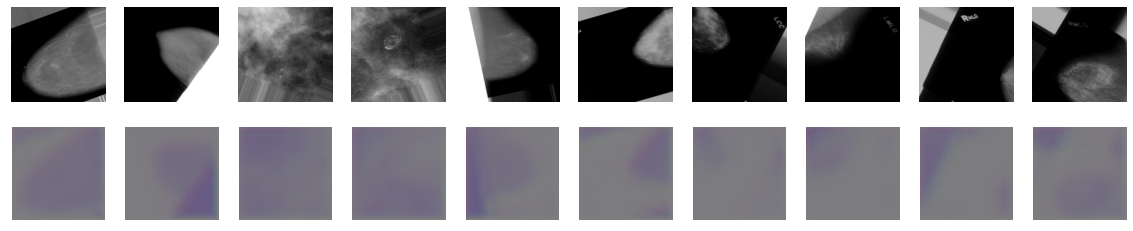

In [ ]:
#compare original images with reconstructions
%matplotlib inline
n = 10
x = train_gen.next()
decoded_imgs = autoencoder.predict(x)


plt.figure(figsize=(20, 4))
for i in range(n):
#     # display original
    ax = plt.subplot(2, n, i+1)
    image = x[i]
    plt.imshow(image.reshape(152, 152, 3)) #RGB image
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(decoded_imgs[i].reshape(152, 152, 3))#RGB image
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


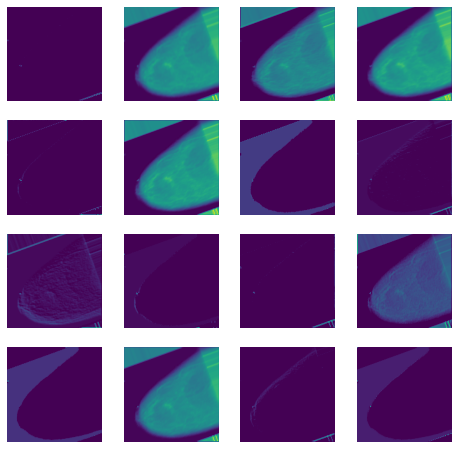

In [ ]:
#visualize activations

try:
    layer_outputs = [layer.output for layer in autoencoder.layers[1:2]]
    activation_model = Model(inputs=autoencoder.input, outputs=layer_outputs)
    activations = activation_model.predict(x)
except:
    pass #avoid any errors

n = activations.shape[-1]

fig=plt.figure(figsize=(8, 8))
rows = 4
columns = n//rows
for i in range(n):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(activations[0, :, :, i])
    plt.axis('off')

In [ ]:
#encoder 
input_img = Input(shape=(152,152, 3)) #RGB image

#same encoder part
x = Conv2D(16,(3,3),activation='relu',padding='same',)(input_img)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D(2,padding='same')(x)

# fully connected layer with output
model = Flatten()(encoded)
model = Dense(1024, activation='elu')(model)
model = keras.layers.BatchNormalization()(model)
model = Dropout(0.5)(model)
model = Dense(1,activation='sigmoid')(model) #output

full_model = Model(input_img, model)


In [ ]:
# copy encoder-model weights 

for l1,l2 in zip(full_model.layers[:7],autoencoder.layers[0:7]):
    l1.set_weights(l2.get_weights())

In [ ]:
#froze encoder layers

for layer in full_model.layers[0:7]:
    layer.trainable = False

In [ ]:
full_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])


In [ ]:
full_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 152, 152, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 152, 152, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 76, 76, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 76, 76, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 19, 8)         0   

In [ ]:
callbacks =keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=20, 
                                        )

In [ ]:
hist = full_model.fit_generator(train_generator,
                                     epochs=10,
                                     steps_per_epoch=10,
                                     validation_data=test_generator,
                                     validation_steps=10,
                                     callbacks=[callbacks])

Epoch 1/10
10/10 [==============================] - 22s 2s/step - loss: 0.2754 - acc: 0.8842 - val_loss: 1.7515 - val_acc: 0.6200
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.3461 - acc: 0.9000 - val_loss: 1.2954 - val_acc: 0.7000
Epoch 3/10
10/10 [==============================] - 24s 2s/step - loss: 0.5116 - acc: 0.7900 - val_loss: 1.0042 - val_acc: 0.6400
Epoch 4/10
10/10 [==============================] - 23s 2s/step - loss: 0.2006 - acc: 0.9053 - val_loss: 1.0086 - val_acc: 0.6800
Epoch 5/10
10/10 [==============================] - 23s 2s/step - loss: 0.2487 - acc: 0.8900 - val_loss: 1.3806 - val_acc: 0.7100
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.1981 - acc: 0.9474 - val_loss: 1.1418 - val_acc: 0.6800
Epoch 7/10
10/10 [==============================] - 24s 2s/step - loss: 0.3613 - acc: 0.8300 - val_loss: 0.8608 - val_acc: 0.6700
Epoch 8/10
10/10 [==============================] - 23s 2s/step - loss: 0.1959 - acc: 0.92

In [ ]:
accuracy = hist.history['acc']
loss = hist.history['loss']
val_accuracy = hist.history['val_acc']
val_loss = hist.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.9473684430122375
Training Loss: 0.1958616077899933
Validation Accuracy: 0.7200000286102295
Validation Loss: 0.8320942521095276


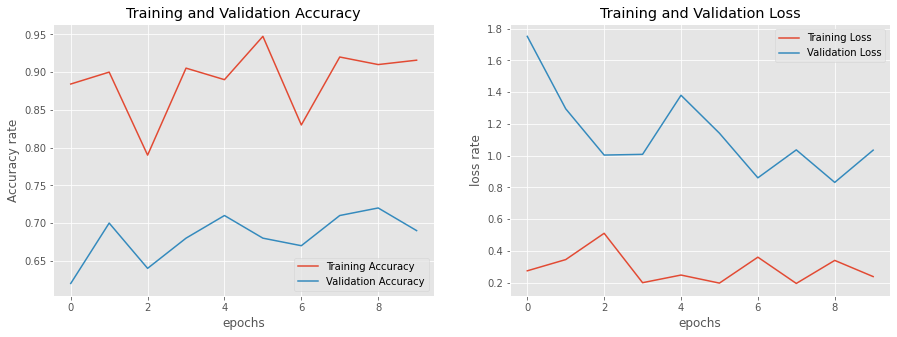

In [ ]:
epochs_range = range(10)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xlabel('epochs')
plt.ylabel('Accuracy rate')
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel('epochs')
plt.ylabel('loss rate')
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
predictions = full_model.predict(test_generator).argmax( axis=-1 ) 

In [ ]:
print(len(predictions))
#predictions.resize(357,refcheck=False)
print(len(predictions))

142
142


In [ ]:
print ( predictions )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
#print(test_set)
print('F1_score : ',f1_score(test_generator.classes,predictions,average='micro'))
print('sensitibity : ',metrics.recall_score(test_generator.classes,predictions,average='micro'))

F1_score :  0.5070422535211268
sensitibity :  0.5070422535211268


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67        72
           1       0.00      0.00      0.00        70

    accuracy                           0.51       142
   macro avg       0.25      0.50      0.34       142
weighted avg       0.26      0.51      0.34       142



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show() 

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

fpr , tpr , thresholds = roc_curve (test_generator.classes,predictions)
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(test_generator.classes,predictions,average='micro') 
print(auc_score) 
print(matthews_corrcoef(test_generator.classes,predictions))